In [1]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 72.8 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 123.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 128.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 35.1 MB/s eta 0:00:00


In [2]:
import glob
import os
from multiprocessing import Pool
from pathlib import Path
import pickle

import h5py
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hdmf_zarr import NWBZarrIO

import utils.nwb_dict_utils as nwb_utils
from utils.preprocess import batch_processing

In [3]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.copy_on_write = True

In [4]:
def RMSE(x,y):
    return np.sqrt(np.mean((x-y)**2, -1))

def bias(x,y):
    return np.mean(x-y, -1)

def std_of_diff(x,y):
    return np.std(x-y, -1)

def corr(x, y):
    x = np.array(x)
    y = np.array(y)
    x = x-x.mean(-1)[...,None]
    x /= x.std(-1)[...,None]
    y = y-y.mean(-1)[...,None]
    y /= y.std(-1)[...,None]
    return np.mean(x*y, -1)

In [5]:
parents = sorted(glob.glob("/data/photometry/vary*"))
parents

['/data/photometry/vary_a_max',
 '/data/photometry/vary_a_power',
 '/data/photometry/vary_attenuation',
 '/data/photometry/vary_b_bright',
 '/data/photometry/vary_b_fast',
 '/data/photometry/vary_b_inf',
 '/data/photometry/vary_b_slow',
 '/data/photometry/vary_corr_s',
 '/data/photometry/vary_decay',
 '/data/photometry/vary_motion_power',
 '/data/photometry/vary_noise_std',
 '/data/photometry/vary_t_bright',
 '/data/photometry/vary_t_fast',
 '/data/photometry/vary_t_slow']

In [6]:
def evaluate(parent):
    perf_dff = []
    perf_pp = []
    params = []
    dFFs = []
    PPs = []
    vary = parent.split('/')[-1][5:]
    for nwb_file in sorted(glob.glob(f"{parent}/*/*.nwb")):
        print(f"Processing NWB file: {nwb_file}")
        p = pd.read_csv(Path(nwb_file).parent / "parameters.csv", delimiter=",", index_col=0)
        p = list(p[vary])
        params.append([p[:3], p[3:6]])
        with h5py.File(Path(nwb_file).parent / 'groundtruth.h5') as file:
            dFF_gt = [file[f'fiber{f}']['dff'][:] for f in (0,1)]

        with NWBZarrIO(path=nwb_file, mode="r") as io:
            nwb = io.read()
            # convert nwb to dataframe
            df_from_nwb = nwb_utils.nwb_to_dataframe(nwb)
            # add the session column
            filename = Path(nwb_file).name
            session_name = filename.split(".")[0].split("FIP_")[1]
            df_from_nwb.insert(0, "session", session_name)
            # now pass the dataframe through the preprocessing function:
            df_fip_pp_nwb, df_PP_params, df_fip_mc = batch_processing(df_fip=df_from_nwb)
            # calculate performance measures
            tmp, tmp2 = [], []
            dFF, PP = [], []
            for pre in ("poly", "exp", "bright"):
                df = df_fip_pp_nwb[df_fip_pp_nwb["preprocess"]==pre]
                dFF.append(np.array([[df[(df["channel"] == ch) & (df["fiber_number"] == fiber)]["signal"]
                                 for ch in ['Iso', 'G', 'R']] for fiber in df_fip_pp_nwb["fiber_number"].unique()]))
                tmp.append([RMSE(dFF[-1], dFF_gt), bias(dFF[-1], dFF_gt), std_of_diff(dFF[-1], dFF_gt), corr(dFF[-1], dFF_gt)])
                df = df_fip_mc[df_fip_mc["preprocess"]==pre]
                PP.append(np.array([[df[(df["channel"] == ch) & (df["fiber_number"] == fiber)]["signal"]
                                 for ch in ['Iso', 'G', 'R']] for fiber in df_fip_mc["fiber_number"].unique()]))
                tmp2.append([RMSE(PP[-1], dFF_gt), bias(PP[-1], dFF_gt), std_of_diff(PP[-1], dFF_gt), corr(PP[-1], dFF_gt)])
            perf_dff.append(tmp)
            dFFs.append(dFF)
            perf_pp.append(tmp2)
            PPs.append(PP)

    return (np.array(params),  # indices: expId, fiber, channel
            np.array(perf_dff),# indices: expId, method, performance_measure, fiber, channel
            np.array(dFFs),    # indices: expId, method, fiber, channel, frame
            np.array(perf_pp), # indices: expId, method, performance_measure, fiber, channel
            np.array(PPs))    # indices: expId, method, fiber, channel, frame

In [7]:
%%time
%%capture
results = Pool(int(os.environ['CO_CPUS'])).map(evaluate, parents)

CPU times: user 8.09 s, sys: 7.38 s, total: 15.5 s
Wall time: 21h 42min 55s


In [8]:
# Save to a pickle file
with open('/scratch/comparison_dff+mc.pkl', 'wb') as f:
    pickle.dump(results, f)

#### Create comparison plot 

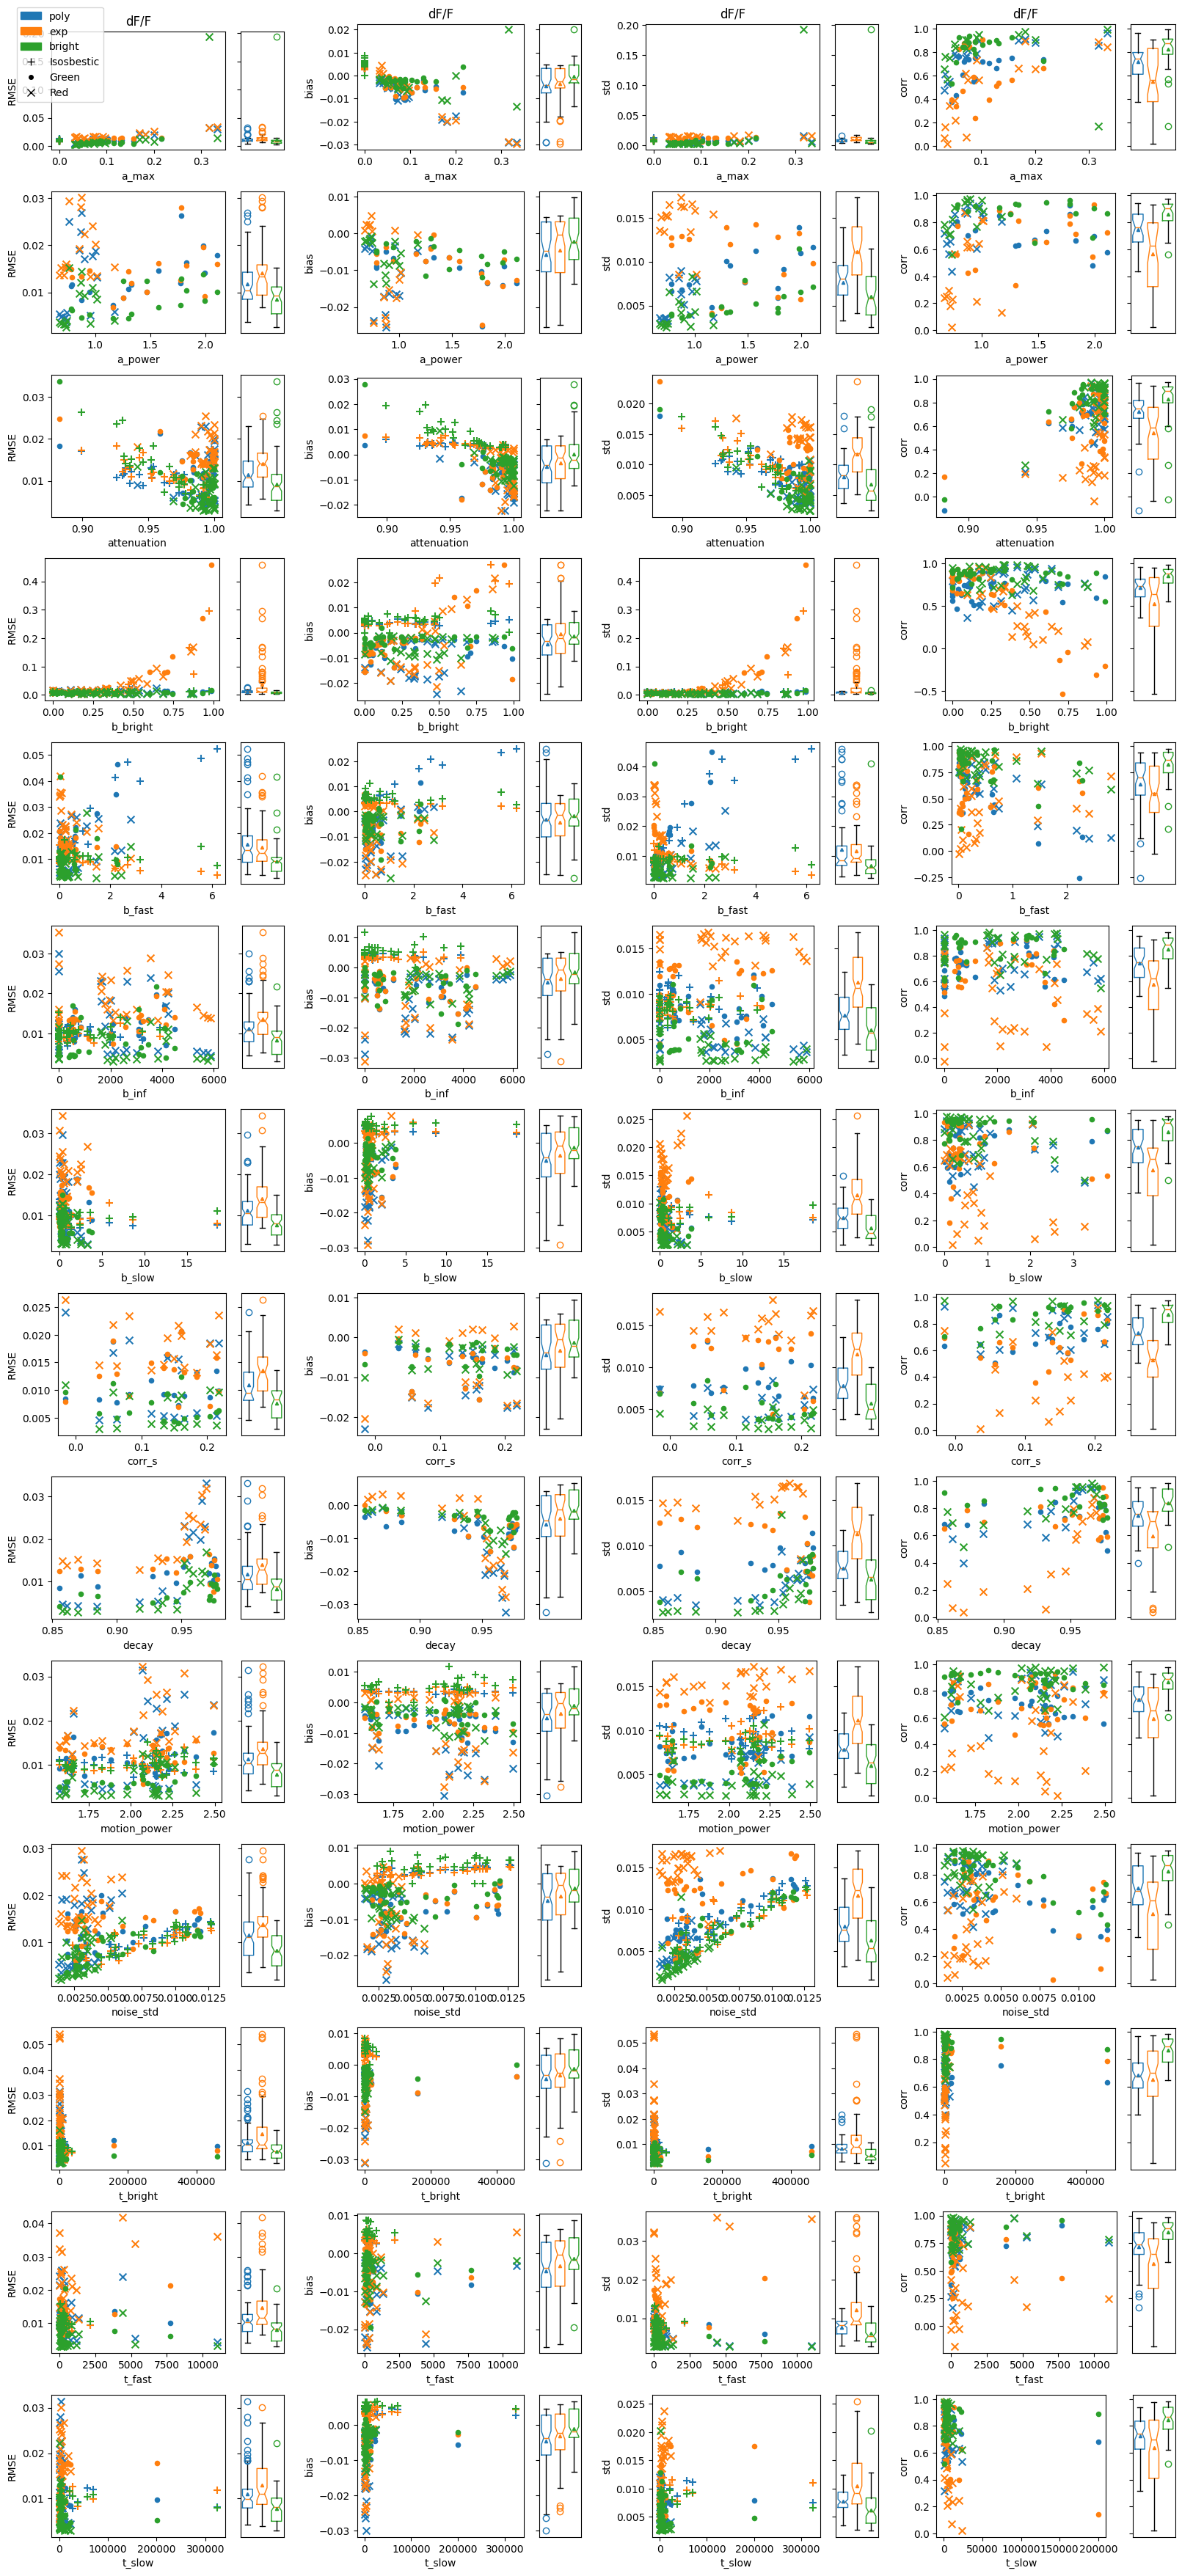

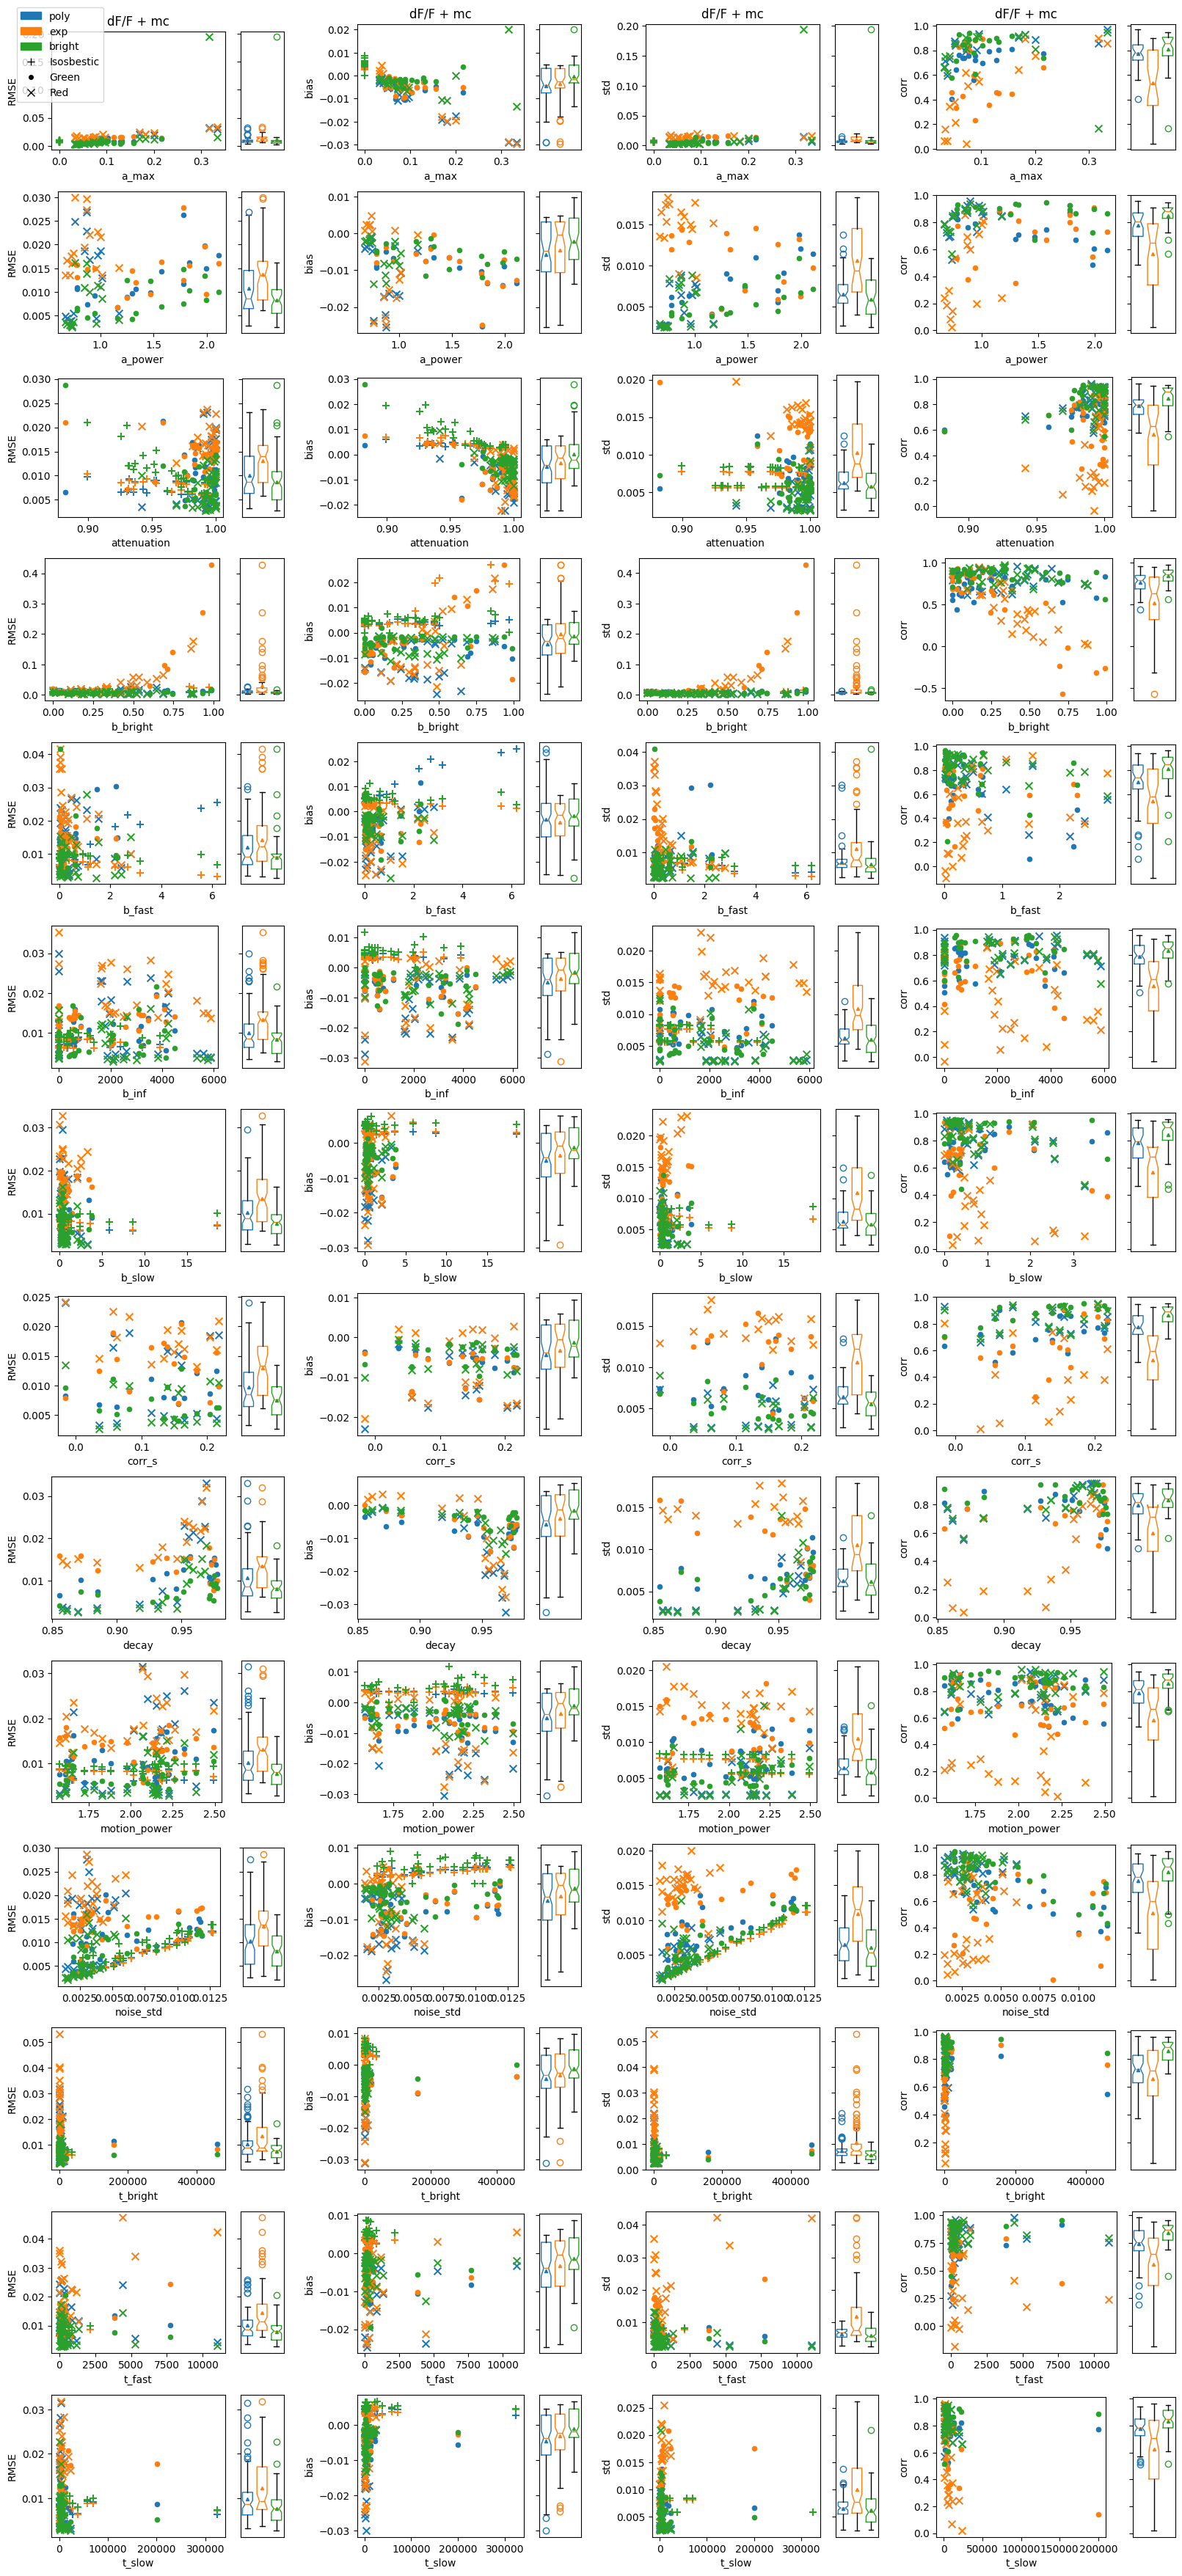

In [9]:
rows = len(results)
for pre in ("dff", "dff+mc"):
    fig = plt.figure(layout="constrained", figsize=(16,2.5*rows))
    subfigs = fig.subfigures(rows, 4, wspace=0.05)
    for row in range(rows):
        params = results[row][0]
        perf = results[row][1 if pre=="dff" else 3]
        vary = parents[row].split('/')[-1][5:]
        for col in range(4):
            ax0, ax1 = subfigs[row, col].subplots(1, 2, width_ratios=[4, 1], sharey=True)
            for k in range(len(perf[0])):
                ax0.scatter(params[...,0].ravel(), perf[:,k,col,:,0].ravel(), c=f'C{k}', s=50, marker='+')
                ax0.scatter(params[...,1].ravel(), perf[:,k,col,:,1].ravel(), c=f'C{k}', s=20, marker='o')
                ax0.scatter(params[...,2].ravel(), perf[:,k,col,:,2].ravel(), c=f'C{k}', s=50, marker='x')
                tmp = perf[:,k,col].ravel()
                ax1.boxplot(tmp[~np.isnan(tmp)],
                            positions=[k], widths=.7, showmeans=True, notch=True,
                            boxprops=dict(color=f'C{k}'), flierprops=dict(markeredgecolor=f'C{k}'),
                            meanprops=dict(markerfacecolor=f'C{k}', markeredgecolor=f'C{k}', markersize=3))
                ax1.set_xticks([])
            if col+row==0:
                ax0.legend(handles=[Patch(color='C0', label='poly'),
                                    Patch(color='C1', label='exp'),
                                    Patch(color='C2', label='bright'),
                                    Line2D([], [], color='k', markersize=7, marker='+', linestyle='None', label='Isosbestic'),
                                    Line2D([], [], color='k', markersize=4, marker='o', linestyle='None', label='Green'),
                                    Line2D([], [], color='k', markersize=7, marker='x', linestyle='None', label='Red')],
                          loc=(-.2,.4))
            ax0.set_xlabel(vary)
            ax0.set_ylabel(['RMSE', 'bias', 'std', 'corr'][col])
            if row==0:
                ax0.set_title('dF/F' if pre=="dff" else 'dF/F + mc')
    plt.savefig(f"/scratch/comparison_{pre}.pdf")

In [10]:
# RMSE of dF/F for each method over all simulations
print(np.mean([[results[row][1][:,m,0].mean() for m in (0,1,2)] for row in range(rows)], 0))
print(np.sum([[results[row][1][:,m,0].sum() for m in (0,1,2)] for row in range(rows)], 0))

[0.01165849 0.01566359 0.00844572]
[12.06533871 16.43548433  8.63265604]


In [11]:
# RMSE of dF/F+mc for each method over all simulations
print(np.mean([[results[row][3][:,m,0].mean() for m in (0,1,2)] for row in range(rows)], 0))
print(np.sum([[results[row][3][:,m,0].sum() for m in (0,1,2)] for row in range(rows)], 0))

[0.01032861 0.01459007 0.00828059]
[10.66439576 15.24620716  8.45869913]


In [17]:
# Corr of dF/F for each method over all simulations
print(np.nanmean([[np.nanmean(results[row][1][:,m,3]) for m in (0,1,2)] for row in range(rows)], 0))
print(np.nansum([[np.nansum(results[row][1][:,m,3]) for m in (0,1,2)] for row in range(rows)], 0))

[0.72032325 0.56934706 0.84784221]
[494.03316495 392.69011486 583.36875291]


In [18]:
# Corr of dF/F+mc for each method over all simulations
print(np.nanmean([[np.nanmean(results[row][3][:,m,3]) for m in (0,1,2)] for row in range(rows)], 0))
print(np.nansum([[np.nansum(results[row][3][:,m,3]) for m in (0,1,2)] for row in range(rows)], 0))

[0.76723652 0.56588457 0.83860758]
[526.55550786 390.1121023  576.95174139]


In [12]:
# median values for each parameter
for parent in parents:
    vary = parent.split('/')[-1][5:]
    qq=[np.array(pd.read_csv(Path(nwb_file).parent / "parameters.csv", delimiter=",", index_col=0)[vary])
          for nwb_file in sorted(glob.glob(f"{parent}/*/*.nwb"))]
    print(vary, np.nanmedian(qq))

a_max 0.0559529356349044
a_power 0.9676361102731483
attenuation 0.990376054752377
b_bright 0.2588575845115088
b_fast 0.20126156478658955
b_inf 1124.1582304257604
b_slow 0.37137221696565875
corr_s 0.14418202106487135
decay 0.9531218852674423
motion_power 2.086924324699142
noise_std 0.0038102636392726
t_bright 2073.122248162862
t_fast 220.42119205670485
t_slow 3712.1658291263648


#### Create plots of traces for all 3 $\Delta$F/F methods 

In [7]:
# Load from a pickle file
with open('/scratch/comparison_dff+mc.pkl', 'rb') as f:
    results = pickle.load(f)

In [8]:
plt.ioff()  # Turn interactive plotting off

def plot(p, pre="dff"):
    parent = parents[p]
    dFFs = results[p][2 if pre=="dff" else 4]
    for n, nwb_file in enumerate(sorted(glob.glob(f"{parent}/*/*.nwb"))):
        print(f"Processing NWB file: {nwb_file}")
        with h5py.File(Path(nwb_file).parent / 'groundtruth.h5') as file:
            dFF_gt = [file[f'fiber{f}']['dff'][:] for f in (0,1)]

        with NWBZarrIO(path=nwb_file, mode="r") as io:
            nwb = io.read()
            # convert nwb to dataframe
            df_from_nwb = nwb_utils.nwb_to_dataframe(nwb)
            
        outdir = Path("/scratch") / parent.split('/')[-1] / nwb_file.split('/')[-2]
        os.makedirs(outdir, exist_ok=True)

        for f in (0,1):
            for c in (0,1,2):
                fs = 20
                time_seconds = np.arange(np.shape(dFF_gt)[-1]) / fs
                raw = df_from_nwb[(df_from_nwb["fiber_number"] == str(f+1)) & (df_from_nwb["channel"] == ('Iso', 'G', 'R')[c])]["signal"].values
                
                fig = plt.figure(figsize=(15,5))
                # We'll use two separate gridspecs to have different margins, hspace, etc
                gs_top = plt.GridSpec(5, 1, top=0.92, hspace=.25)
                gs_base = plt.GridSpec(5, 1, hspace=.15)
                # Top (unshared) axes
                topax = fig.add_subplot(gs_top[0,:])
                # The four shared axes
                ax0 = fig.add_subplot(gs_base[1,:], sharex=topax) # Need to create the first one to share...
                other_axes = [fig.add_subplot(gs_base[i,:], sharex=topax, sharey=ax0) for i in range(2, 5)]
                ax = [ax0] + other_axes
                # Hide shared x-tick labels
                for a in ax[:-1]:
                    plt.setp(a.get_xticklabels(), visible=False)
                
                topax.plot(time_seconds, raw, c='k')
                topax.set_title("raw", y=.65, size=11)
                topax.set_ylabel('F [a.u.]')
                for i in (0,1,2):
                    ax[i].plot(time_seconds, 100*dFFs[n,i,f,c], c=f"C{i}")
                    ax[i].set_title(("poly", "exp", "bright")[i], c=f"C{i}", y=.65, size=11)
                ax[2].set_ylabel(r'$\Delta$F/F (%)', y=1.12)
                ax[3].plot(time_seconds, 100*np.array(dFF_gt)[f,c], c='k')
                ax[3].set_title("ground truth", y=.65, size=11)
                ax[3].set_xlim(0, time_seconds[-1])
                ax[3].set_xlabel('Time [seconds]')
                plt.savefig(outdir / f"Fiber{f+1}_{('Iso', 'G', 'R')[c]}_{pre}", bbox_inches='tight', pad_inches=.05)

In [9]:
%%time
%%capture
Pool(int(os.environ['CO_CPUS'])).map(plot, range(len(parents)))

CPU times: user 36.8 ms, sys: 474 ms, total: 511 ms
Wall time: 2min 35s


In [10]:
def plot_pp(p):
    return plot(p, "dff+mc")

In [11]:
%%time
%%capture
Pool(int(os.environ['CO_CPUS'])).map(plot_pp, range(len(parents)))

CPU times: user 28.7 ms, sys: 460 ms, total: 489 ms
Wall time: 2min 27s
